In [80]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder , StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , classification_report , precision_recall_curve, confusion_matrix , roc_curve , auc

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier , VotingClassifier ,  AdaBoostClassifier , GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

In [50]:
data = pd.read_csv('Loan Status.csv')

## Data Analysis and Feature Engineering
 ---

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [52]:
data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [53]:
data.dropna(inplace = True)
data = data.drop(columns=['Loan_ID'])

In [54]:
enc = OrdinalEncoder() # As all are just categories
scaler = StandardScaler() 
numeric_columns = list(data.select_dtypes(['int64' , 'float64']).columns)
categorical_columns = list(data.select_dtypes('object').columns)

<Axes: >

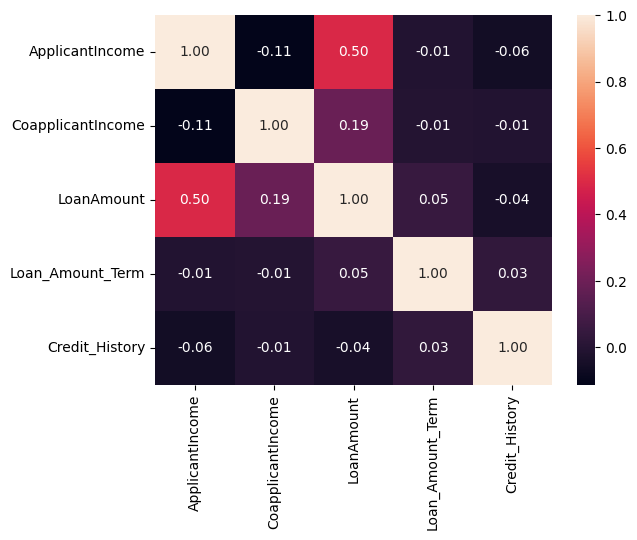

In [56]:
corr_matrix = data[numeric_columns].corr()
sns.heatmap(corr_matrix , annot = True , fmt = '.2f') 
# Couldn't draw much information from the Correlation matrix

In [57]:
data_pipeline = ColumnTransformer([
    ('Normalization' , scaler , numeric_columns),
    ('OrdinalEncoder' , enc , categorical_columns)
])
scaled_data = data_pipeline.fit_transform(data)

In [58]:
preprocessed_data = pd.DataFrame(scaled_data , columns = numeric_columns + categorical_columns)

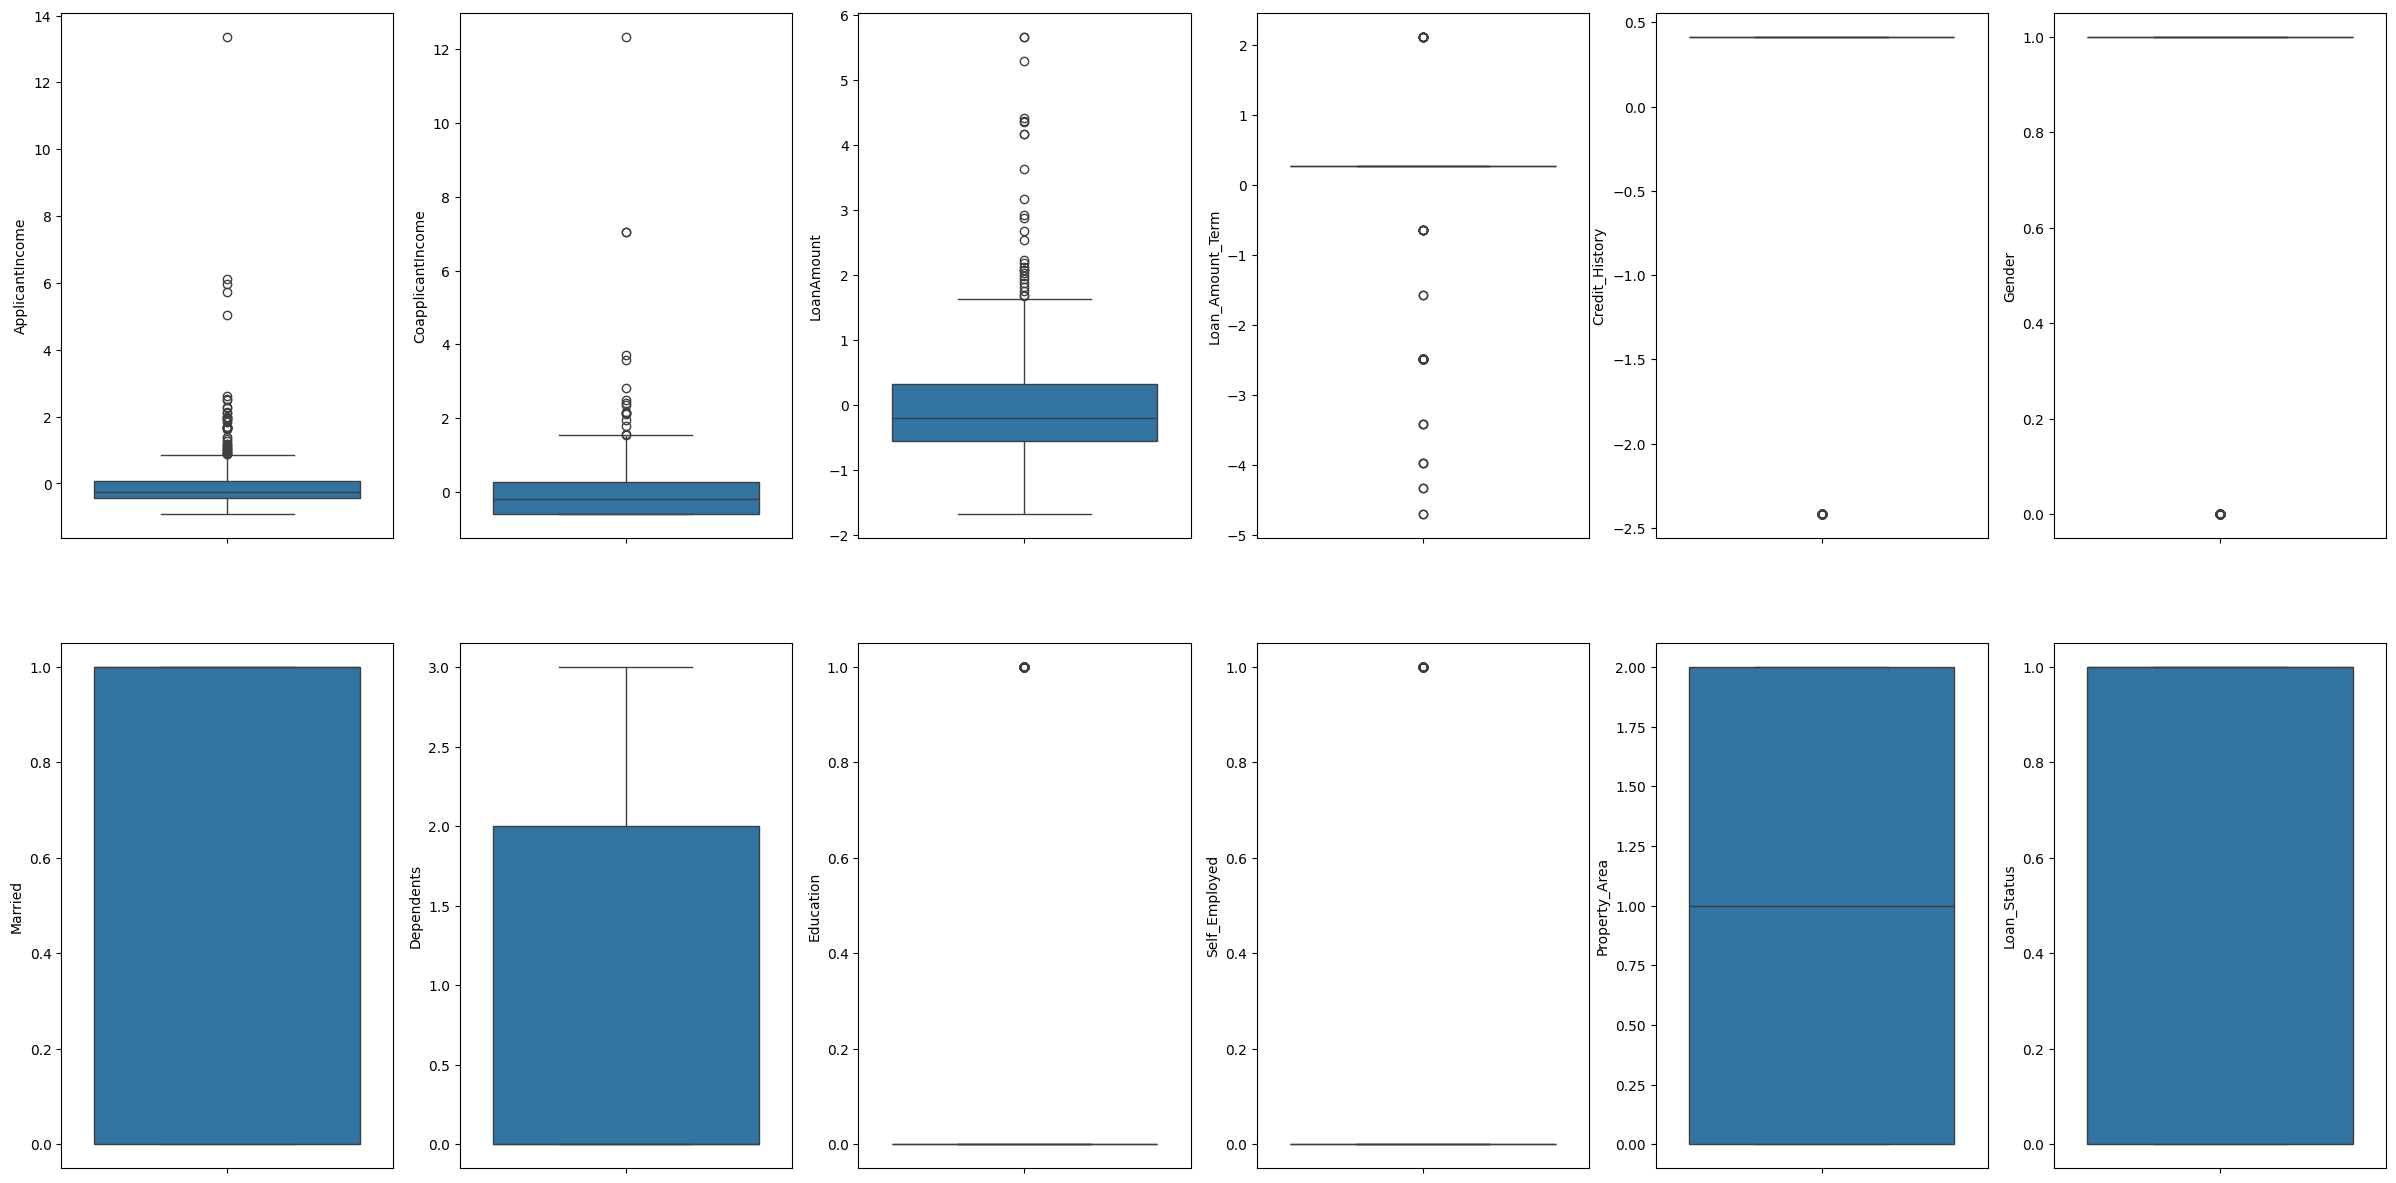

In [59]:
fig , axes= plt.subplots(nrows = 2 , ncols = 6 , figsize = (30 , 15))
for i in range(12):
    sns.boxplot(preprocessed_data.iloc[: , i] , ax = axes[i // 6][i % 6])
# boxplot to observe check for outliers , Outcome : reasonable

In [60]:
target = preprocessed_data['Loan_Status']
preprocessed_data.drop(columns = ['Loan_Status'] , inplace = True)

In [61]:
x_train , x_test , y_train , y_test = train_test_split(np.array(preprocessed_data) , np.array(target) , test_size=0.2)

## Training Different Models
---

In [62]:
# Initializing different Models
voting_clf = VotingClassifier(estimators = [('model1' , SVC()), ('model2' , LogisticRegression()) , ('model3', RandomForestClassifier()) , ('model4' , DecisionTreeClassifier())])
MODEL_SET ={
                'log_clf' : LogisticRegression() , 
                'xg_boost' : XGBClassifier() , 
                'svc' : SVC(),
                'd-trees' : DecisionTreeClassifier() , 
                'RF_clf' : RandomForestClassifier() , 
                'GB_clf' : GradientBoostingClassifier(),
                'Ada_clf': AdaBoostClassifier(),
                'voting_clf' : voting_clf
            }

In [63]:
# training different models
best_model_names = []
for name , model in MODEL_SET.items():
    model.fit(x_train, y_train)
    train_predict = model.predict(x_train)
    acc = accuracy_score(train_predict , y_train)
    if acc > 0.95:
        best_model_names.append(name)
    print(f'the training error of {name} is : {accuracy_score(train_predict , y_train)}')

the training error of log_clf is : 0.8255208333333334
the training error of xg_boost is : 1.0
the training error of svc is : 0.8411458333333334
the training error of d-trees is : 1.0
the training error of RF_clf is : 1.0
the training error of GB_clf is : 0.9296875
the training error of Ada_clf is : 0.859375
the training error of voting_clf is : 0.9869791666666666


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### Analysis
   <p> Based on the performance of the models without optimization
   We can consider 5 models that gave good results
   XGboost , DecisionTrees , RandomForest , Voting Classifier<p>

## Hyperparameter tuning

In [65]:
algos = {
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'splitter': ['best', 'random']
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [10, 50, 100, 130],
            'max_depth': range(2, 5, 1),
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_features': ['sqrt', 'log2']
        }
    },
    'XGBClassifier': {
        'model': XGBClassifier(),
        'params': {
            'learning_rate': [0.5, 0.1, 0.01, 0.001],
            'max_depth': [2, 3],
            'n_estimators': [10, 50, 100, 200]
        }
    },
    'VotingClassifier': {
        'model': VotingClassifier([
            ('model1', SVC(probability=True)),
            ('model2', LogisticRegression()),
            ('model3', RandomForestClassifier()),
            ('model4', DecisionTreeClassifier())
        ]),
        'params': {
            'voting': ['soft']
        }
    }
}

final_models = []

for algorithm_name, config in algos.items():
    model = config['model']
    param_grid = config['params']
    
    # Perform grid search
    gscv = GridSearchCV(model, param_grid, cv=10)
    gscv.fit(x_train, y_train)
    
    final_models.append({
        'name': algorithm_name,
        'model': gscv.best_estimator_,
        'score': gscv.best_score_
    })

In [66]:
for item in final_models:
    print(f"{item['name']} best_score : {item['score']}")
    # Lets evaluate over test data
    prediction = item['model'].predict(x_test)
    print(f'Test Accuracy : {accuracy_score(prediction , y_test)}\n') 

decision_tree best_score : 0.7444669365721996
Test Accuracy : 0.6354166666666666

RandomForestClassifier best_score : 0.8256410256410256
Test Accuracy : 0.75

XGBClassifier best_score : 0.823076923076923
Test Accuracy : 0.7291666666666666

VotingClassifier best_score : 0.80748987854251
Test Accuracy : 0.75



In [72]:
# Classification Report For Random Forest Regressor
model = final_models[2]['model']
prediction = model.predict(x_test)
print(f'XGBoost Classifier: \n {classification_report(prediction , y_test)}')


XGBoost Classifier: 
               precision    recall  f1-score   support

           0       0.26      1.00      0.41         9
           1       1.00      0.70      0.82        87

    accuracy                           0.73        96
   macro avg       0.63      0.85      0.62        96
weighted avg       0.93      0.73      0.79        96



## Visulizations

Text(0.5, 1.0, 'Confusion Matrix')

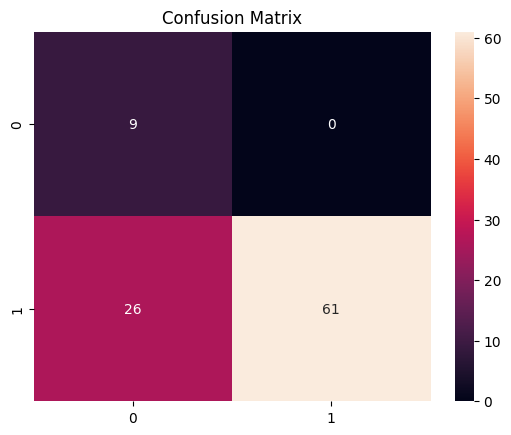

In [77]:
confusion_mat = confusion_matrix(prediction , y_test)
sns.heatmap(confusion_mat , annot = True)
plt.title('Confusion Matrix')

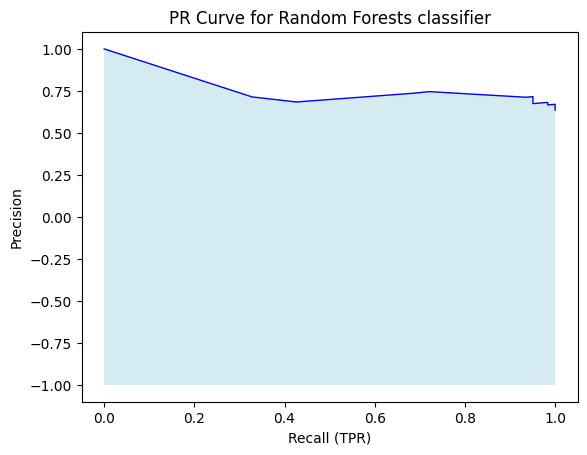

In [78]:
# Lets draw precision , Recall curve for the Model
proba = model.predict_proba(x_test)
proba = np.max(proba , axis = 1)

precisions , recalls , thresholds = precision_recall_curve(y_test , proba)
plt.plot(recalls, precisions, lw=1, color='blue')
plt.fill_between(recalls, precisions, -1, facecolor='lightblue', alpha=0.5)
plt.title('PR Curve for Random Forests classifier')
plt.xlabel('Recall (TPR)')
plt.ylabel('Precision')
plt.show()

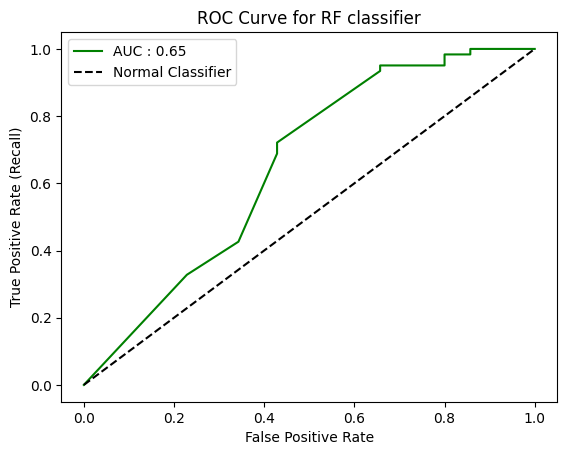

In [79]:
fpr, tpr, thresholds = roc_curve(y_test, proba)

auc_value = auc(fpr , tpr)
plt.plot(fpr, tpr , color='green' , label = f'AUC : {auc_value:.2f}')
plt.plot(fpr , fpr , '--' , color = 'black' , label = "Normal Classifier")
plt.title('ROC Curve for RF classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend()
plt.show()